In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import resultcomp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plots
import json
import numpy as np
import os
mpl.rcParams['figure.dpi'] = 300
results_dir = './../../results'

In [19]:
region = 'saopaulo'

In [20]:
if region == 'netherlands':
    start = 'netherlands-20200518_235511'
    end = 'netherlands-baseline'
else:
    start = 'saopaulo-20200518_170056'
    end = 'saopaulo-baseline'

In [21]:
def string_range(strings, start=None, end=None):
    keep = []
    include = False
    for string in strings:
        if string.startswith(start):
            include = True
        if include:
            keep.append(string)
        if end is not None and string.startswith(end):
            include = False
    return keep

In [22]:
result_directories = sorted(os.listdir(results_dir))
directories = string_range(result_directories, start, end)
df = pd.DataFrame(columns=['scale', 'directory', 'p', 'gamma', 'beta', 'mse'])

In [23]:
metrics = None
for d in directories:
    p = "{}/{}/distance-metrics.csv".format(results_dir, d)
    if not os.path.exists(p):
        continue
    s = pd.read_csv(p)
    s = s.assign(run_id=d).set_index(['run_id', 'distance'])
    if metrics is None:
        metrics = s
    else:
        metrics = pd.concat([metrics, s])

In [24]:
def mse(dms, df):
    sq_errs = np.square(np.subtract(dms['groundtruth_sum'], dms['model_sum']))
    for model in dms.index.get_level_values(level=0).unique():
        if model != region + '-baseline':
            with open(results_dir + '/' + model+ '/parameters.json') as f:
                d = json.load(f)
            
            df2 = pd.DataFrame({'directory': [model], 'p': [d['model']['p']], 'gamma': [d['model']['gamma']], 'beta': [d['model']['region_sampling']['beta']], 'mse': [sq_errs.loc[model].mean()]})
        else:
            df2 = pd.DataFrame({'directory': [model], 'p': [None], 'gamma': [None], 'beta': [None], 'mse': [sq_errs.loc[model].mean()]})
        df = df.append(df2)
    return df

In [25]:
df = pd.DataFrame(columns=['directory', 'p', 'gamma', 'beta', 'mse'])
df = mse(metrics, df).set_index('directory')

In [26]:
df.sort_values('mse')

,p,gamma,beta,mse
directory,,,,
saopaulo-20200519_012631,0.9,0.5,0.07,0.000004
saopaulo-20200518_232330,0.9,0.8,0.04,0.000004
saopaulo-20200519_034525,0.6,0.5,0.04,0.000004
saopaulo-20200519_004100,0.3,0.5,0.04,0.000006
saopaulo-20200519_044402,0.6,0.8,0.04,0.000006
saopaulo-20200518_233716,0.3,0.2,0.04,0.000007
saopaulo-20200519_054047,0.3,0.2,0.07,0.000008
saopaulo-20200518_221646,0.9,0.5,0.04,0.000010
saopaulo-20200519_014158,0.3,0.8,0.04,0.000011


Text(0.5, 1.02, 'B')

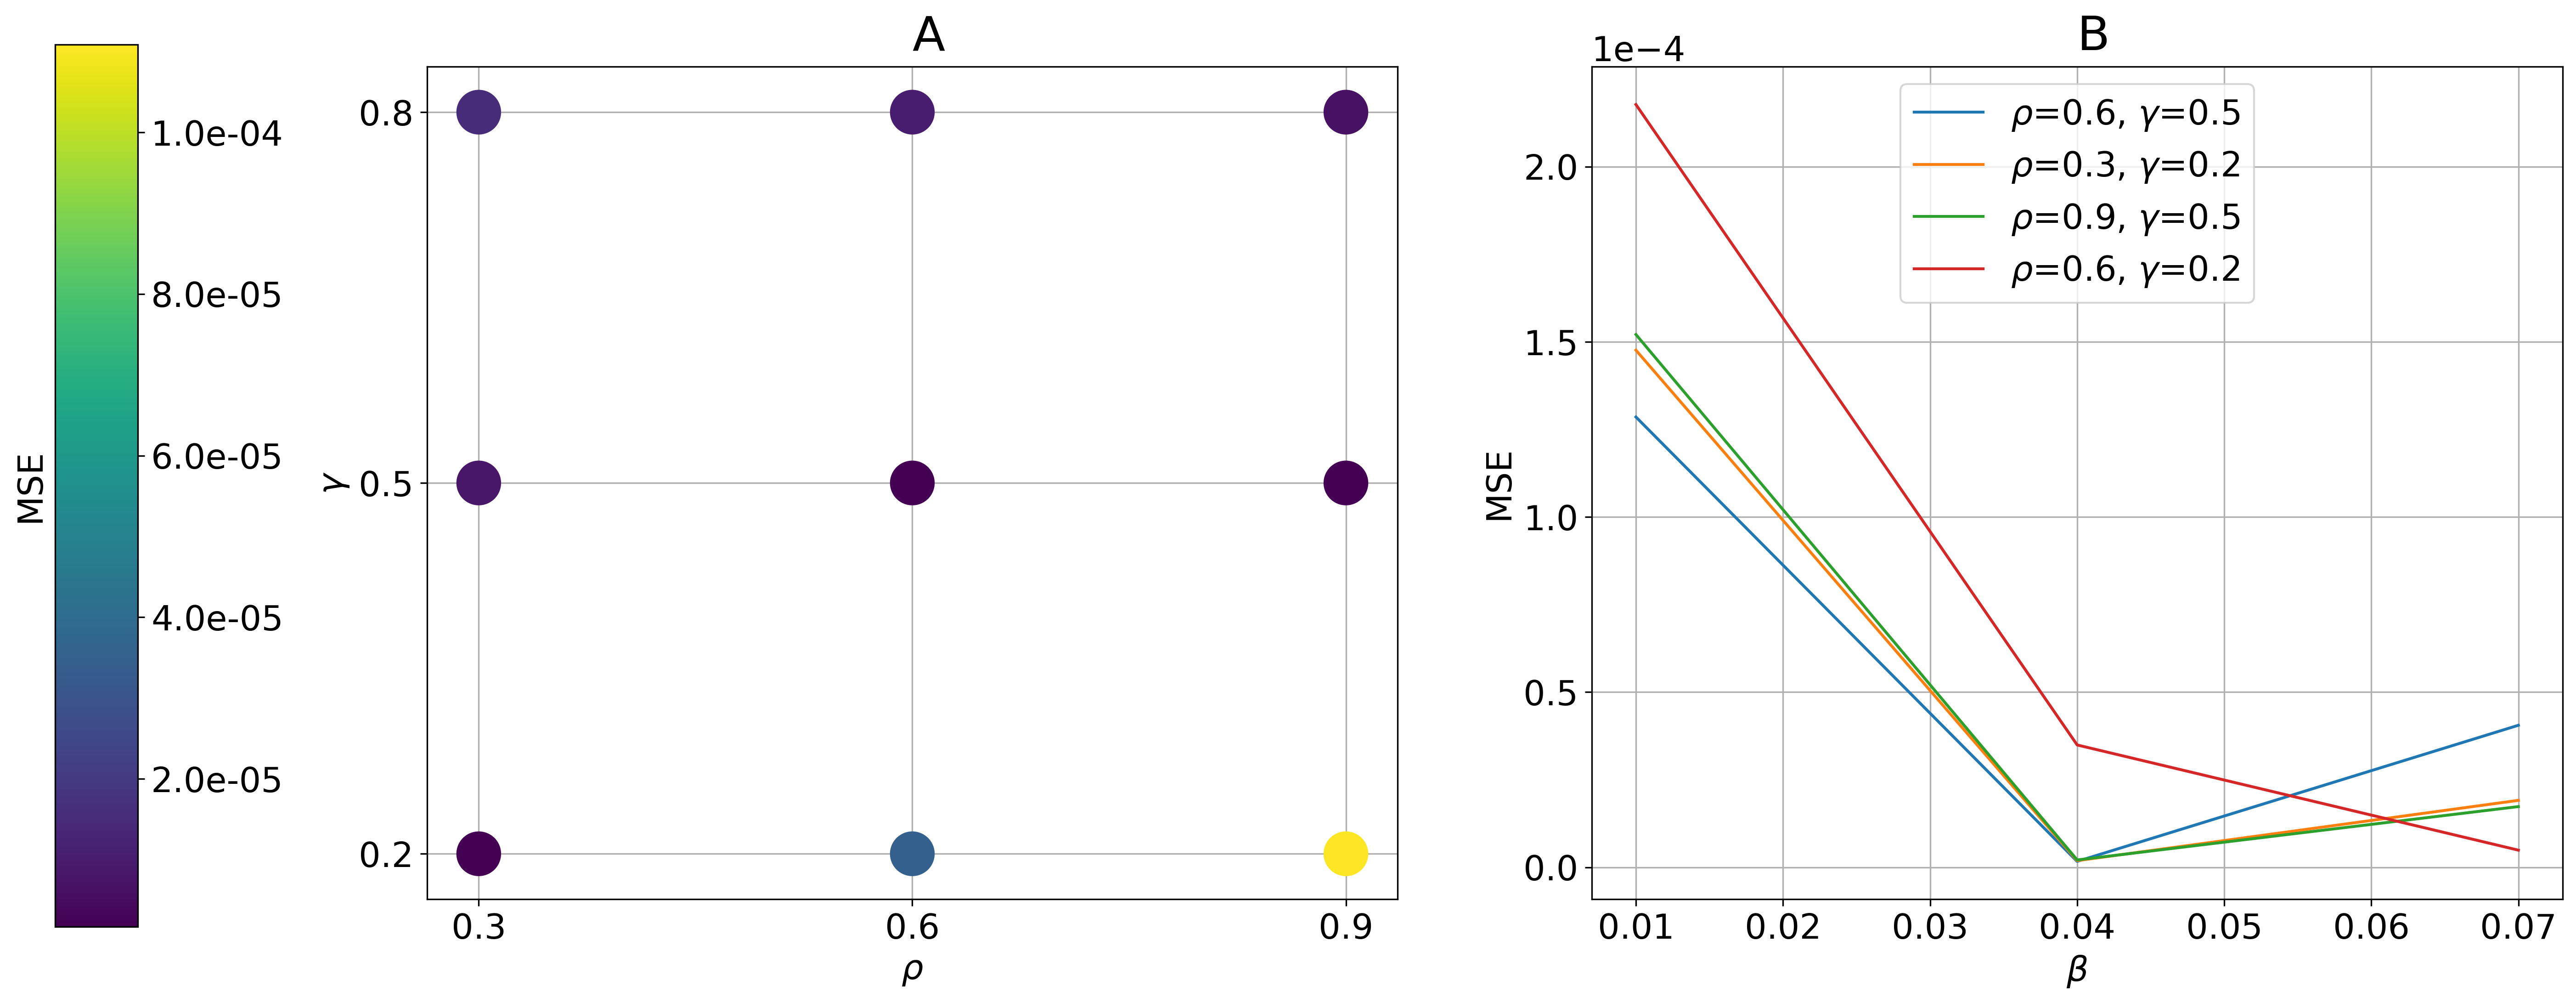

In [112]:
from matplotlib.ticker import StrMethodFormatter
mpl.rcParams['font.size'] = 18.0
exploration_plot_data = df[df.beta == 0.04]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.set_xticks([0.3, 0.6, 0.9])
ax1.set_yticks([0.2, 0.5, 0.8])
s = ax1.scatter(
    exploration_plot_data.p, 
    exploration_plot_data.gamma, 
    c=exploration_plot_data.mse,
    s=500,
    zorder=2
)
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'$\gamma$')
ax1.grid(True)
ax1.text(.5, 1.02, "A", transform=ax1.transAxes, fontsize='25')
cbaxes = fig.add_axes([-0.01, 0.1, 0.03, 0.8])
cbar = fig.colorbar(s, ax=ax1, format='%.1e', cax=cbaxes)
cbar.ax.set_ylabel('MSE', rotation=90)
cbar.ax.yaxis.set_label_position('left')

for (p,gamma) in [[0.6,0.5], [0.3,0.2], [0.9, 0.5], [0.6,0.2]]:
    beta_plot_data = df[(df.p == p) & (df.gamma == gamma)].sort_values(by='beta')
    ax2.plot(beta_plot_data.beta, beta_plot_data.mse, label=r'$\rho$={}, $\gamma$={}'.format(p,gamma))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax2.grid(True)
ax2.legend(loc='upper center')
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel('MSE')
ax2.text(.5, 1.02, "B", transform=ax2.transAxes, fontsize='25')